# An initial training pipeline

In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()

c:\Users\ADYL\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\ADYL\AppData\Local\Temp\ipykernel_23564\4071503124.py:6: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be 

## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [2]:
returns = df[[ 'returns']].dropna()
returns.describe()

,returns
count,2.011280e+06
mean,4.661458e-03
std,3.381753e-01
min,-9.973097e-01
25%,-9.227211e-03
50%,5.008512e-04
75%,1.028043e-02
max,2.090455e+02


In [3]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns)

StandardScaler()

In [4]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
scaled_returns = pd.DataFrame(scaled_returns_np, columns=returns.columns)
scaled_returns.describe()

,returns
count,2.011280e+06
mean,1.837050e-19
std,1.000000e+00
min,-2.962876e+00
25%,-4.106944e-02
50%,-1.230311e-02
75%,1.661557e-02
max,6.181436e+02


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='sector'>

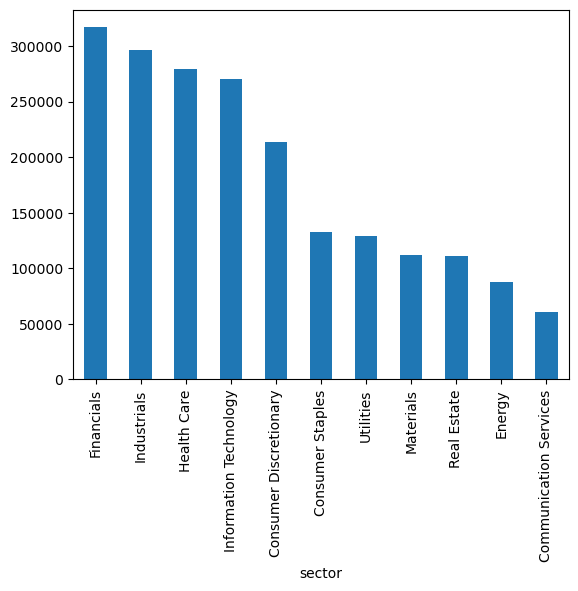

In [5]:
df['sector'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [6]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['sector']])

OneHotEncoder()

In [7]:
sector_enc = onehot.transform(df[['sector']])
sector_enc.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [9]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [10]:
X0 = df[['sector']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [11]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [12]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [13]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5116511624438169,
 'accuracy_score_test': 0.5111744759556104,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'log_loss_train': 0.6928522320977067,
 'log_loss_test': 0.6928865573765879,
 'f1_score_train': 0.6769434313359095,
 'f1_score_test': 0.6765260849609873}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [14]:
from sklearn.compose import ColumnTransformer

In [15]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['sector']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

In [16]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['sector']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [17]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [18]:
# Schema
X = df[['returns', 'Volume', 'sector']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [19]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6922697393770026,
 'log_loss_test': 0.6922463049369669,
 'cohen_kappa_train': 0.013411736295578014,
 'cohen_kappa_test': 0.013072883641649158,
 'f1_score_train': 0.6516457347612601,
 'f1_score_test': 0.6516304384238983,
 'accuracy_score_train': 0.5154266678785816,
 'accuracy_score_test': 0.515274778204192}

In [20]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6881464777572005,
 'log_loss_test': 0.7718000684226587,
 'cohen_kappa_train': 0.03059429677005443,
 'cohen_kappa_test': 0.015170761274382327,
 'f1_score_train': 0.6317724450101961,
 'f1_score_test': 0.6258525541925325,
 'accuracy_score_train': 0.5217806760155032,
 'accuracy_score_test': 0.5141716256739329}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [21]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [22]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,20.399786,1.020202,0.513151,0.522157,0.628373,0.633744,0.515470,0.521254,0.804603,0.808147,0.512314,0.527096,-0.806264,-0.688302,-0.252000,-0.248003
1,19.287961,1.023878,0.513397,0.522077,0.623327,0.630730,0.515989,0.521486,0.787055,0.797873,0.512296,0.527360,-0.778013,-0.688358,-0.251326,-0.248019
2,25.112968,1.423286,0.514829,0.522815,0.635503,0.639934,0.516097,0.521120,0.826792,0.828927,0.512054,0.528648,-0.763105,-0.687846,-0.251107,-0.247822
3,25.203995,1.355184,0.513695,0.522036,0.627597,0.633033,0.515896,0.521236,0.801037,0.805884,0.512665,0.527081,-0.772387,-0.688100,-0.251284,-0.247929
4,26.548017,1.418674,0.513546,0.521233,0.619745,0.629832,0.516349,0.520970,0.774917,0.796208,0.509308,0.526311,-0.910563,-0.688334,-0.253899,-0.248055


In [23]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,19.642309,1.011272,0.513146,0.522149,0.628576,0.633779,0.515453,0.521245,0.805313,0.808284,0.512275,0.527072,-0.805130,-0.688310,-0.251978,-0.248007
1,19.298100,1.033318,0.513402,0.522077,0.623336,0.630739,0.515992,0.521485,0.787074,0.797905,0.512297,0.527358,-0.779304,-0.688358,-0.251343,-0.248019
2,18.957137,1.021119,0.514846,0.522821,0.635522,0.639938,0.516107,0.521123,0.826831,0.828931,0.512085,0.528659,-0.762395,-0.687839,-0.251090,-0.247820
3,18.820151,1.021765,0.513683,0.522037,0.627589,0.633037,0.515888,0.521236,0.801027,0.805896,0.512637,0.527083,-0.772833,-0.688090,-0.251296,-0.247926
4,19.345267,1.034652,0.513596,0.521230,0.619758,0.629828,0.516383,0.520968,0.774883,0.796201,0.509415,0.526307,-0.909643,-0.688332,-0.253864,-0.248054


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [24]:
pd.DataFrame(d15_dict).mean()

fit_time                 19.212593
score_time                1.024425
test_accuracy             0.513735
train_accuracy            0.522063
test_f1                   0.626956
train_f1                  0.633464
test_precision            0.515965
train_precision           0.521211
test_recall               0.799026
train_recall              0.807443
test_roc_auc              0.511742
train_roc_auc             0.527296
test_neg_log_loss        -0.805861
train_neg_log_loss       -0.688186
test_neg_brier_score     -0.251914
train_neg_brier_score    -0.247965
dtype: float64